In [1]:
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from PIL import Image
from pydicom import dcmread
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard

In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size=3, stride=2, padding=1
            ),
            nn.BatchNorm2d(features_d),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 3, 2, 1),
            self._block(features_d * 2, features_d * 4, 3, 2, 1),
            self._block(features_d * 4, features_d * 8, 3, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=3, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(0.2),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            nn.ConvTranspose2d(
                channels_noise, features_g * 16, 4, 1, 0
            ),
            nn.LeakyReLU(0.2),
#             self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

## Hyperparameters

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1
NOISE_DIM = 256
NUM_EPOCHS = 100
FEATURES_DISC = 64
FEATURES_GEN = 64
TRAIN_DIR = "/Storage/PauloOctavioDir/nodule_rois/gan/adeno/images"
MIN_HU_VALUE = -1024
MAX_HU_VALUE = 1000
TENSORBOARD_MODEL_NAME = "dcgan"

In [4]:
train_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
#         transforms.CenterCrop(432),
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

## Dataset

In [5]:
def normalize(image):
    min_val = MIN_HU_VALUE
    max_val = MAX_HU_VALUE
    image[image < min_val] = min_val
    image[image > max_val] = max_val
    image = (image - min_val) / (max_val - min_val)
    return image

In [6]:
class LungNoduleDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        images = os.listdir(image_dir)
        if 'rtss.dcm' in images: images.remove('rtss.dcm')
        self.images = images


    def __len__(self):
         return len(self.images)


    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        data = dcmread(img_path)
        image = np.array(data.pixel_array).astype('float32')
        # Conversio to HU
        intercept = int(data.RescaleIntercept)
        slope = int(data.RescaleSlope)
        image = (slope * image) + intercept
        image = normalize(image)
        return self.transform(image)
    
dataset = LungNoduleDataset(image_dir=TRAIN_DIR, transform=train_transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Min: -0.9924654364585876 
Max: 0.3122028112411499


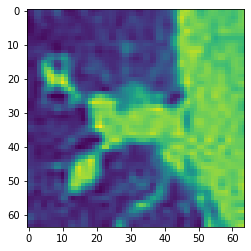

In [7]:
# %matplotlib notebook 
import random
image = dataset[random.randint(0, len(dataset))][0].cpu().detach().numpy()
print(f"Min: {image.min()} \nMax: {image.max()}")
plt.imshow(image)
plt.show()

## Training

In [8]:
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer = SummaryWriter(f"logs/{TENSORBOARD_MODEL_NAME}")
step = 0

gen.train()
disc.train()

start = time.time()
for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for batch_idx, real in enumerate(loader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer.add_image("Real", img_grid_real, global_step=step)
                writer.add_image("Fake", img_grid_fake, global_step=step)
                writer.add_scalar("data/loss_dis", loss_disc.item(), global_step=step)
                writer.add_scalar("data/loss_gen", loss_gen.item(), global_step=step)

            step += 1
end = time.time()
duration = end - start
print("Finshed Training.")
print(f"Training duration: {datetime.timedelta(seconds=duration)}")

Epoch [0/100] Batch 0/26                   Loss D: 0.6911, loss G: 0.7123
Epoch [1/100] Batch 0/26                   Loss D: 0.4891, loss G: 1.0024
Epoch [2/100] Batch 0/26                   Loss D: 0.3111, loss G: 1.3561
Epoch [3/100] Batch 0/26                   Loss D: 0.2248, loss G: 1.7101
Epoch [4/100] Batch 0/26                   Loss D: 0.1367, loss G: 2.1034
Epoch [5/100] Batch 0/26                   Loss D: 0.0987, loss G: 2.4275
Epoch [6/100] Batch 0/26                   Loss D: 0.0695, loss G: 2.5660
Epoch [7/100] Batch 0/26                   Loss D: 0.0564, loss G: 3.0273
Epoch [8/100] Batch 0/26                   Loss D: 0.3291, loss G: 2.2346
Epoch [9/100] Batch 0/26                   Loss D: 0.2791, loss G: 2.1206
Epoch [10/100] Batch 0/26                   Loss D: 0.1769, loss G: 2.2913
Epoch [11/100] Batch 0/26                   Loss D: 0.7559, loss G: 2.5105
Epoch [12/100] Batch 0/26                   Loss D: 0.2009, loss G: 2.2236
Epoch [13/100] Batch 0/26          

NameError: name 'datetime' is not defined